# Basic regression analysis of the housing data
Fit a series of regression models for the housing data.
1. A macro model mapping GDP, Unemployment, and the Case-Shiller index. This gives a long history.
2. A model mapping between changes in the Case-Shiller index and the average sale price across all counties.
3. Use model (1) on the predictions from model (2) to get a model which explains macro-level impacts on county-level housing prices.
4. Take the difference between individual sale prices and the prediction from model (3) to get cross-sectional residuals at the county level
5. Model county-level effects separately

## Setup and load data

In [135]:
import numpy as np, pandas as pd
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import re, locale
pd.options.mode.chained_assignment = None
locale.setlocale(locale.LC_NUMERIC, '')

'English_United States.1252'

In [2]:
macroData  = pd.read_csv('macroData.csv').set_index('Month')
homeData = pd.read_csv('combined_home_data.csv')

C:\Users\Michael\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,169,245,284,288,292,304,308,312,348,352,356) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Macro model: Case-Shiller vs. Mortage Rate
Possible expansion: throw the kitchen sink of macro variables in and use cross-validation and LASSO or ridge to select variables. Given e.g. a 3-month diff, should we expect the data series to be sufficiently stationary?

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

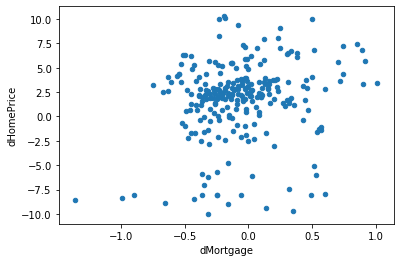

In [29]:
regPd = 3
regData = macroData[['Case-Shiller Index','GDP','30-Year Mortgage Rate']]
regData.loc[:,'dHomePrice'] = regData['Case-Shiller Index'].diff(periods=regPd)
regData.loc[:,'dGDP'] = np.log(regData['GDP']).diff(periods=regPd)
regData.loc[:,'dMortgage'] = regData['30-Year Mortgage Rate'].diff(periods=regPd)
regData = regData.dropna()
macroData.head()
regData.plot.scatter(x='dMortgage',y='dHomePrice')

Text(0, 0.5, 'QoQ change in Case-Shiller index (%)')

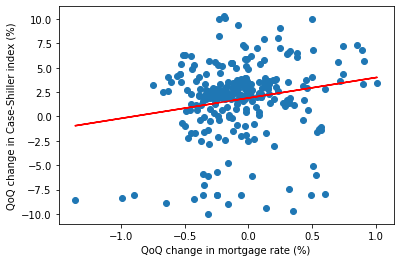

In [39]:
macroModel = lm.LinearRegression()
X = regData['dMortgage'].values.reshape(-1,1)
y = regData['dHomePrice'].values
macroModel.fit(X,y)

plt.scatter(X,y)
plt.plot(X,macroModel.predict(X), color='red')
plt.xlabel('QoQ change in mortgage rate (%)')
plt.ylabel('QoQ change in Case-Shiller index (%)')

## Case-Shiller vs. Population-Weighted Median Sale Price

In [111]:
# Determine population for each region_id based on period_begin
homeData['POP_ESTIMATE_2020'] = homeData['POP_ESTIMATE_2019'] # fill last year forward
homeData['POP_ESTIMATE_2021'] = homeData['POP_ESTIMATE_2019'] # fill last year forward
homeData['Population'] = homeData.apply(lambda x: x['POP_ESTIMATE_' + str(x.period_begin.year)], axis=1)

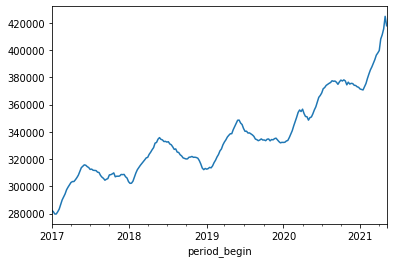

In [164]:
# Calculate the average median sale price by county, weighted by population
redfinIdx = homeData[['period_begin','Population','median_sale_price']].dropna()
redfinIdx['Population'] = redfinIdx['Population'].apply(locale.atof)
redfinIdx = redfinIdx.groupby(redfinIdx['period_begin']).apply(lambda x: np.average(x.median_sale_price, weights=x.Population))
redfinIdx.plot()

In [276]:
# Calculate MoM changes and align to Case-Shiller
redfinChg = redfinIdx.pct_change(periods=4)
redfinChg, _ = redfinChg.align(macroData, join='right', method='ffill')
houseRegData = redfinChg.to_frame(name='Redfin')
macroData.index = pd.to_datetime(macroData.index)
houseRegData['dHomePrice'] = macroData['Case-Shiller Index'].diff(1)
houseRegData.dropna(inplace=True)
houseRegData.head()

,Redfin,dHomePrice
Month,,
2017-07-31,-0.002762,1.149574
2017-08-31,-0.002762,1.028716
2017-09-30,-0.002762,1.233827
2017-10-31,-0.002762,1.051167
2017-11-30,-0.002762,1.205222


Text(0, 0.5, 'MoM change in Redfin Pop-Weighted Index (%)')

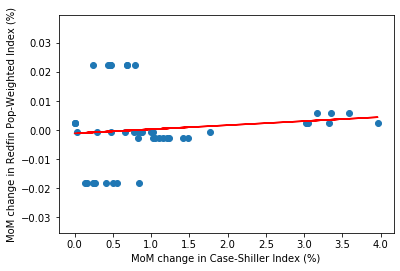

In [277]:
# Fit a model relating the two
housingModel = lm.LinearRegression(normalize=True)
X = houseRegData[['dHomePrice']].values
y = houseRegData[['Redfin']].values
housingModel.fit(X, y)
plt.scatter(X, y)
plt.plot(X,housingModel.predict(X), color='red')
plt.xlabel('MoM change in Case-Shiller Index (%)')
plt.ylabel('MoM change in Redfin Pop-Weighted Index (%)')

## Combine previous two models to forecast the market-wide housing trend

In [295]:
housingModel.predict(macroModel.predict(regData[['dMortgage']]).reshape(-1,1)).flatten()

array([ 1.15920985e-03,  2.41808024e-03,  1.48124646e-03,  1.51052252e-03,
       -3.33868986e-04,  5.15136627e-04,  1.93100015e-04,  7.49345072e-04,
       -6.85181654e-04, -4.11084298e-05, -2.75316875e-04,  8.66449295e-04,
        1.42269435e-03,  1.74473096e-03,  2.09604363e-03,  1.24703802e-03,
        6.90792961e-04,  3.68756349e-04,  3.68756349e-04,  1.80328308e-03,
        2.79866897e-03,  2.44735630e-03,  8.95725351e-04,  1.56907463e-03,
        1.27631407e-03,  1.36414224e-03, -3.33868986e-04, -7.03844855e-05,
       -7.03844855e-05, -1.28936597e-04,  1.42269435e-03,  1.24703802e-03,
        1.33486619e-03,  3.10204238e-04,  5.15136627e-04,  1.45197041e-03,
        1.18848591e-03,  1.05271848e-04, -4.50973209e-04,  1.94966335e-03,
        4.46740414e-03,  3.67695064e-03,  1.51052252e-03,  2.51652127e-04,
        1.12993380e-03,  7.49345072e-04,  6.02964794e-04,  1.93100015e-04,
        2.47663236e-03,  3.67695064e-03,  3.99898725e-03,  1.71545491e-03,
        4.67197371e-05, -